In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import math
from scipy.stats import iqr
from numpy import linalg
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy import stats
import time
from tqdm import tqdm

In [2]:
## Features

def mean(x, y, z):
    """Calculates mean"""
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    mean_z = np.mean(z)
    return mean_x, mean_y, mean_z

def std_dev(x, y, z):
    """Calculates standard deviation"""
    std_x = np.std(x)
    std_y = np.std(y)
    std_z = np.std(z)
    return std_x, std_y, std_z  
    
def mad(x, y, z):
    """Calculates median absolute deviation"""
    mad_x = np.median(np.abs(x - np.median(x)))
    mad_y = np.median(np.abs(y - np.median(y)))
    mad_z = np.median(np.abs(z - np.median(z)))
    return mad_x, mad_y, mad_z

def minimum(x, y, z):
    """Calculates minimum"""
    return min(x), min(y), min(z)

def maximum(x, y, z):
    """Calculates maximum"""
    return max(x), max(y), max(z)

def energy_measure(x, y, z):
    """Calculates energy measures"""
    em_x = np.mean(np.square(x))
    em_y = np.mean(np.square(y))
    em_z = np.mean(np.square(z))
    return em_x, em_y, em_z

def inter_quartile_range(x, y, z):
    """Calculates inter-quartile range"""
    iqr_x = np.subtract(*np.percentile(x, [75, 25]))
    iqr_y = np.subtract(*np.percentile(y, [75, 25]))
    iqr_z = np.subtract(*np.percentile(z, [75, 25]))
    return iqr_x, iqr_y, iqr_z

def sma(x, y, z):
    """Calculates signal magnitude area"""   
    abs_x = np.absolute(x)
    abs_y = np.absolute(y)
    abs_z = np.absolute(z)
    return np.mean(abs_x+abs_y+abs_z)

def skewness(x, y, z):
    """Calculates skewness"""
    skew_x=stats.skew(x)
    skew_y=stats.skew(y)
    skew_z=stats.skew(z)
    return skew_x, skew_y, skew_z

def kurt(x, y, z):
    """Calculates kurtosis"""
    kurt_x = stats.kurtosis(x,fisher=False)
    kurt_y = stats.kurtosis(y,fisher=False)
    kurt_z = stats.kurtosis(z,fisher=False)
    return kurt_x, kurt_y, kurt_z
    
def max_index(x, y, z):
    """Calculates index of maximum"""
    idx_x = np.argmax(x)
    idx_y = np.argmax(y)
    idx_z = np.argmax(z)
    return idx_x, idx_y, idx_z

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y



In [3]:
def process_acc(input_df, columns, output_df, freq_flag):
    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 10000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 5000
            max_window -= 5000
            i -= int(count/2)
        x = [input_df[1][i]]
        y = [input_df[2][i]]
        z = [input_df[3][i]]
        
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[1][i])
                y.append(input_df[2][i])
                z.append(input_df[3][i])
                min_window = input_df[0][i]
            except KeyError:
                break

        sma_val = (sma(x,y,z), )
        
        if freq_flag == 0:
            acc_data = list(mean(x, y, z)+std_dev(x, y, z)+mad(x, y, z)+minimum(x, y, z)+maximum(x, y, z)+energy_measure(x, y, z)+inter_quartile_range(x, y, z)+sma_val)
        
        
        else:
            acc_data = list(mean(x, y, z)+std_dev(x, y, z)+mad(x, y, z)+minimum(x, y, z)+maximum(x, y, z)+energy_measure(x, y, z)+inter_quartile_range(x, y, z)+sma_val+
                            skewness(x, y, z)+kurt(x, y, z)+max_index(x, y, z))
        
        
       # acc_data = list(mean(x, y, z)+std_dev(x, y, z)+mad(x, y, z)+minimum(x, y, z)+maximum(x, y, z)+energy_measure(x, y, z)+inter_quartile_range(x, y, z)+sma_val)
        output_df = output_df.append(pd.Series(acc_data, index=columns), ignore_index=True)

    return output_df

In [4]:
def process_gyr(input_df, columns, output_df, freq_flag):

    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 10000
        min_window = input_df[0][i]
        if i != 0:                                                                 #handling overlap
            min_window -= 5000
            max_window -= 5000
            i -= int(count/2)
        x = [input_df[1][i]]
        y = [input_df[2][i]]
        z = [input_df[3][i]]
        l = input_df[5][i]
        
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[1][i])
                y.append(input_df[2][i])
                z.append(input_df[3][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        
        l = (l, )  
        sma_val = (sma(x,y,z), )
        
        if freq_flag == 0:
            gy_data = list(mean(x, y, z)+std_dev(x, y, z)+mad(x, y, z)+minimum(x, y, z)+maximum(x, y, z)+energy_measure(x, y, z)+inter_quartile_range(x, y, z)+sma_val+l)
        
        
        else:
            gy_data = list(mean(x, y, z)+std_dev(x, y, z)+mad(x, y, z)+minimum(x, y, z)+maximum(x, y, z)+energy_measure(x, y, z)+inter_quartile_range(x, y, z)+sma_val+
                            skewness(x, y, z)+kurt(x, y, z)+max_index(x, y, z)+l)
        
        #gy_data = list(mean(x, y, z)+std_dev(x, y, z)+mad(x, y, z)+minimum(x, y, z)+maximum(x, y, z)+energy_measure(x, y, z)+inter_quartile_range(x, y, z)+sma_val+label) 
        output_df = output_df.append(pd.Series(gy_data, index=columns), ignore_index=True)
        
    return output_df

In [5]:
def process_mag(input_df, columns, output_df, freq_flag):
    mag = np.linalg.norm(input_df.iloc[:,1:4], axis = 1)
    input_df[6] = mag.tolist()
    
    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 10000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 5000
            max_window -= 5000
            i -= int(count/2)
        x = [input_df[6][i]]
        
        
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                label = input_df[5][i]
                if label=='null' or label is None:
                    continue
                x.append(input_df[6][i])
                min_window = input_df[0][i]
            except KeyError:
                break
                
        label = (input_df[5][1], )
        if label == 'null':
            print('--------null')
            return
        
        mean = (np.mean(x),)
        std_dev = (np.std(x),)
        mad = (np.median(np.abs(x - np.median(x))),)
        minimum = (np.min(x),)
        maximum = (np.max(x),)
        energy_measure = (np.mean(np.square(x)),)
        inter_quartile_range = (np.subtract(*np.percentile(x, [75, 25])),)
        sma_val = (np.mean(np.absolute(x)),)
        
        if freq_flag == 0:
            acc_data = list(mean+std_dev+mad+minimum+maximum+energy_measure+inter_quartile_range+sma_val)
        else:
            skew = (stats.skew(x),)
            kur = (stats.kurtosis(x,fisher=False),)
            m_idx = (np.argmax(x),)
            acc_data = list(mean+std_dev+mad+minimum+maximum+energy_measure+inter_quartile_range+sma_val+skew+kur+m_idx)
        
        #acc_data = list(mean+std_dev+mad+minimum+maximum+energy_measure+inter_quartile_range+sma_val)
        output_df = output_df.append(pd.Series(acc_data, index=columns), ignore_index=True)

    return output_df

In [6]:
def hist_activities(df):
    df['label'].value_counts().plot(kind='bar', title='Training examples by activity type')
    plt.show()
    
def plot_activity(activity, df):
    data = df[df.iloc[:, 5] == activity][[1, 2, 3]][:2000]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
def plot_act_signals(df):
    plot_activity("sitting", df)
    plt.ylabel('sitting')
    plt.show()
    plot_activity("walking", df)
    plt.ylabel('walking')
    plt.show()
    plot_activity("standing", df)
    plt.ylabel('standing')
    plt.show()
    plot_activity("laying_down", df)
    plt.ylabel('laying_down')
    plt.show()

In [7]:
def calc_jerk(acc, ts):
    jk = [0]* len(acc)
    for i in range(1,len(acc)):
        jk[i-1] = 1000*(acc[i] - acc[i-1])/(ts[i] - ts[i-1])
    return jk

def fmagnitude(num):
    return math.sqrt(num.real**2 + num.imag**2)

In [8]:
def get_session_dirs(path):
    path = path
    dirs = []
    dir_list = [x[0] for x in os.walk(path)]
    last_dirs = ["1_android.sensor.accelerometer.data.csv.gz","4_android.sensor.gyroscope.data.csv.gz"]
    dirs = []
    for each_dir in dir_list[2:]:

        if "data" in each_dir:
            dirs.append(each_dir)

    dirs.sort(key=lambda x:x[-22:])
    return dirs

In [9]:
def get_jerk(df):
    df[1] = calc_jerk(df[1],df[0])
    df[2] = calc_jerk(df[2],df[0])
    df[3] = calc_jerk(df[3],df[0])
    return df

def get_fft(df):
    df[1] = np.fft.fft(df[1])
    df[2] = np.fft.fft(df[2])
    df[3] = np.fft.fft(df[3])
    df[1] = [fmagnitude(j) for j in df[1]]
    df[2] = [fmagnitude(j) for j in df[2]]
    df[3] = [fmagnitude(j) for j in df[3]]
    return df

def five_point_smoothing(df):
    m=np.array(df[1])
    m_smooth = np.zeros(len(m))
    m_smooth = m;
    for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
        m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] + m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
    df[1] = m_smooth
        
    m=np.array(df[2])
    m_smooth = np.zeros(len(m))
    m_smooth = m;
    for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
        m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] + m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
    df[2] = m_smooth
    
    m = np.array(df[3])
    m_smooth = np.zeros(len(m))
    m_smooth = m;
    for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
        m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] + m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
    df[3] = m_smooth
    
    return df

In [10]:
tacc_cols = ['mean_acc_x', 'mean_acc_y', 'mean_acc_z', 
               'std_acc_x', 'std_acc_y', 'std_acc_z', 
               'mad_acc_x', 'mad_acc_y', 'mad_acc_z',
               'min_acc_x', 'min_acc_y', 'min_acc_z', 
               'max_acc_x', 'max_acc_y', 'max_acc_z', 
               'em_acc_x', 'em_acc_y', 'em_acc_z', 
               'iqr_acc_x', 'iqr_acc_y', 'iqr_acc_z', 
               'sma_acc']

tacc_jerk_cols = ['mean_accj_x', 'mean_accj_y', 'mean_accj_z', 
                   'std_accj_x', 'std_accj_y', 'std_accj_z', 
                   'mad_accj_x', 'mad_accj_y', 'mad_accj_z',
                   'min_accj_x', 'min_accj_y', 'min_accj_z', 
                   'max_accj_x', 'max_accj_y', 'max_accj_z', 
                   'em_accj_x', 'em_accj_y', 'em_accj_z', 
                   'iqr_accj_x', 'iqr_accj_y', 'iqr_accj_z', 
                   'sma_accj']

tacc_mag_cols = ['mean_macc', 'std_macc', 'mad_macc', 'min_macc', 'max_macc', 'em_macc', 'iqr_macc', 'sma_macc']

tacc_jmag_cols = ['mean_macc_jerk', 'std_macc_jerk', 'mad_macc_jerk', 'min_macc_jerk', 'max_macc_jerk', 
                     'em_macc_jerk', 'iqr_macc_jerk', 'sma_macc_jerk']

facc_cols = ['mean_facc_x', 'mean_facc_y', 'mean_facc_z', 
               'std_facc_x', 'std_facc_y', 'std_facc_z', 
               'mad_facc_x', 'mad_facc_y', 'mad_facc_z',
               'min_facc_x', 'min_facc_y', 'min_facc_z', 
               'max_facc_x', 'max_facc_y', 'max_facc_z', 
               'em_facc_x', 'em_facc_y', 'em_facc_z', 
               'iqr_facc_x', 'iqr_facc_y', 'iqr_facc_z', 
               'sma_facc',
               'skew_facc_x', 'skew_facc_y', 'skew_facc_z', 
               'kurt_facc_x', 'kurt_facc_y', 'kurt_facc_z', 
               'idx_facc_x', 'idx_facc_y', 'idx_facc_z']

facc_jerk_cols = ['mean_faccj_x', 'mean_faccj_y', 'mean_faccj_z', 
                   'std_faccj_x', 'std_faccj_y', 'std_faccj_z', 
                   'mad_faccj_x', 'mad_faccj_y', 'mad_faccj_z',
                   'min_faccj_x', 'min_faccj_y', 'min_faccj_z', 
                   'max_faccj_x', 'max_faccj_y', 'max_faccj_z', 
                   'em_faccj_x', 'em_faccj_y', 'em_faccj_z', 
                   'iqr_faccj_x', 'iqr_faccj_y', 'iqr_faccj_z', 
                   'sma_faccj',
                   'skew_faccj_x', 'skew_faccj_y', 'skew_faccj_z', 
                   'kurt_faccj_x', 'kurt_faccj_y', 'kurt_faccj_z', 
                   'idx_faccj_x', 'idx_faccj_y', 'idx_faccj_z']

facc_mag_cols = ['mean_mfacc', 'std_mfacc', 'mad_mfacc', 'min_mfacc', 'max_mfacc', 'em_mfacc', 'iqr_mfacc', 'sma_mfacc',
                'skew_mfacc', 'kurt_mfacc',  'idx_mfacc']

facc_jmag_cols = ['mean_mfacc_jerk', 'std_mfacc_jerk', 'mad_mfacc_jerk', 'min_mfacc_jerk', 'max_mfacc_jerk', 
                     'em_mfacc_jerk', 'iqr_mfacc_jerk', 'sma_mfacc_jerk', 'skew_mfacc_jerk', 'kurt_mfacc_jerk',  
                  'idx_mfacc_jerk']

tgy_cols = ['mean_gy_x', 'mean_gy_y', 'mean_gy_z', 
               'std_gy_x', 'std_gy_y', 'std_gy_z', 
               'mad_gy_x', 'mad_gy_y', 'mad_gy_z',
               'min_gy_x', 'min_gy_y', 'min_gy_z', 
               'max_gy_x', 'max_gy_y', 'max_gy_z', 
               'em_gy_x', 'em_gy_y', 'em_gy_z', 
               'iqr_gy_x', 'iqr_gy_y', 'iqr_gy_z', 
               'sma_gy', 'label']

tgy_jerk_cols = ['mean_gyj_x', 'mean_gyj_y', 'mean_gyj_z', 
                   'std_gyj_x', 'std_gyj_y', 'std_gyj_z', 
                   'mad_gyj_x', 'mad_gyj_y', 'mad_gyj_z',
                   'min_gyj_x', 'min_gyj_y', 'min_gyj_z', 
                   'max_gyj_x', 'max_gyj_y', 'max_gyj_z', 
                   'em_gyj_x', 'em_gyj_y', 'em_gyj_z', 
                   'iqr_gyj_x', 'iqr_gyj_y', 'iqr_gyj_z', 
                   'sma_gyj']

tgy_mag_cols = ['mean_mgy', 'std_mgy', 'mad_mgy', 'min_mgy', 'max_mgy', 'em_mgy', 'iqr_mgy', 'sma_mgy']

tgy_jmag_cols = ['mean_mgy_jerk', 'std_mgy_jerk', 'mad_mgy_jerk', 'min_mgy_jerk', 'max_mgy_jerk', 
                     'em_mgy_jerk', 'iqr_mgy_jerk', 'sma_mgy_jerk']
fgy_cols = ['mean_fgy_x', 'mean_fgy_y', 'mean_fgy_z', 
               'std_fgy_x', 'std_fgy_y', 'std_fgy_z', 
               'mad_fgy_x', 'mad_fgy_y', 'mad_fgy_z',
               'min_fgy_x', 'min_fgy_y', 'min_fgy_z', 
               'max_fgy_x', 'max_fgy_y', 'max_fgy_z', 
               'em_fgy_x', 'em_fgy_y', 'em_fgy_z', 
               'iqr_fgy_x', 'iqr_fgy_y', 'iqr_fgy_z', 
               'sma_fgy', 
               'skew_fgy_x', 'skew_fgy_y', 'skew_fgy_z', 
               'kurt_fgy_x', 'kurt_fgy_y', 'kurt_fgy_z', 
               'idx_fgy_x', 'idx_fgy_y', 'idx_fgy_z']

fgy_jerk_cols = ['mean_fgyj_x', 'mean_fgyj_y', 'mean_fgyj_z', 
                   'std_fgyj_x', 'std_fgyj_y', 'std_fgyj_z', 
                   'mad_fgyj_x', 'mad_fgyj_y', 'mad_fgyj_z',
                   'min_fgyj_x', 'min_fgyj_y', 'min_fgyj_z', 
                   'max_fgyj_x', 'max_fgyj_y', 'max_fgyj_z', 
                   'em_fgyj_x', 'em_fgyj_y', 'em_fgyj_z', 
                   'iqr_fgyj_x', 'iqr_fgyj_y', 'iqr_fgyj_z', 
                   'sma_fgyj',
                   'skew_fgyj_x', 'skew_fgyj_y', 'skew_fgyj_z', 
                   'kurt_fgyj_x', 'kurt_fgyj_y', 'kurt_fgyj_z', 
                   'idx_fgyj_x', 'idx_fgyj_y', 'idx_fgyj_z']

fgy_mag_cols = ['mean_mfgy', 'std_mfgy', 'mad_mfgy', 'min_mfgy', 'max_mfgy', 'em_mfgy', 'iqr_mfgy', 'sma_mfgy',
               'skew_mfgy', 'kurt_mfgy',  'idx_mfgy']

fgy_jmag_cols = ['mean_mfgy_jerk', 'std_mfgy_jerk', 'mad_mfgy_jerk', 'min_mfgy_jerk', 'max_mfgy_jerk', 
                     'em_mfgy_jerk', 'iqr_mfgy_jerk', 'sma_mfgy_jerk', 'skew_mfgy_jerk', 'kurt_mfgy_jerk',  'idx_mfgy_jerk']


In [11]:
def process_csv_data(path):
    dirs = get_session_dirs(path)

    out_acc_df = pd.DataFrame(columns = tacc_cols)

    out_acc_jerk_df = pd.DataFrame(columns = tacc_jerk_cols)

    acc_mag = pd.DataFrame(columns = tacc_mag_cols)

    acc_jerk_mag = pd.DataFrame(columns = tacc_jmag_cols)

    out_facc_df = pd.DataFrame(columns = facc_cols)

    out_facc_jerk_df = pd.DataFrame(columns = facc_jerk_cols)

    facc_mag = pd.DataFrame(columns = facc_mag_cols)

    facc_jerk_mag = pd.DataFrame(columns = facc_jmag_cols)

    out_gy_df = pd.DataFrame(columns = tgy_cols)

    out_gy_jerk_df = pd.DataFrame(columns = tgy_jerk_cols)

    gy_mag = pd.DataFrame(columns = tgy_mag_cols)

    gy_jerk_mag = pd.DataFrame(columns = tgy_jmag_cols)

    out_fgy_df = pd.DataFrame(columns = fgy_cols)

    out_fgy_jerk_df = pd.DataFrame(columns = fgy_jerk_cols)

    fgy_mag = pd.DataFrame(columns = fgy_mag_cols)

    fgy_jerk_mag = pd.DataFrame(columns = fgy_jmag_cols)

    acc_gy_df = pd.DataFrame()

    for i in tqdm(range(len(dirs))): 
        full_path_acc = os.path.normpath(dirs[i] + "/" + "1_android.sensor.accelerometer.data.csv.gz")
        full_path_gy = os.path.normpath(dirs[i] + "/" + "4_android.sensor.gyroscope.data.csv.gz")
    

        print("processing acceleration: " + full_path_acc)
        in_df_ac = pd.read_csv(full_path_acc, compression='gzip', sep=',', header=None)
        
        if in_df_ac.shape[0] > 3000:
    
            in_df_ac = in_df_ac.drop(list(range(1000)), axis = 0)
            in_df_ac.index = range(in_df_ac.shape[0])
            in_df_ac = in_df_ac.drop(list(range(in_df_ac.shape[0]-1000, in_df_ac.shape[0])), axis = 0)
            in_df_ac.index = range(in_df_ac.shape[0])

            
        in_df_ac = five_point_smoothing(in_df_ac)
    
        in_df_ac_jerk = in_df_ac.copy()
        in_df_ac_jerk = get_jerk(in_df_ac_jerk)

        in_df_fac = in_df_ac.copy()
        in_df_fac = get_fft(in_df_fac)

        in_df_fac_jerk = in_df_ac_jerk.copy()
        in_df_fac_jerk = get_fft(in_df_fac_jerk)

        out_acc_df = process_acc(in_df_ac, tacc_cols, out_acc_df, 0)
        out_acc_jerk_df = process_acc(in_df_ac_jerk, tacc_jerk_cols, out_acc_jerk_df, 0)
        out_facc_df = process_acc(in_df_fac, facc_cols, out_facc_df, 1)
        out_facc_jerk_df = process_acc(in_df_fac_jerk, facc_jerk_cols, out_facc_jerk_df, 1)

        acc_mag = process_mag(in_df_ac, tacc_mag_cols, acc_mag, 0)
        acc_jerk_mag = process_mag(in_df_ac_jerk, tacc_jmag_cols, acc_jerk_mag, 0)
        facc_mag = process_mag(in_df_fac, facc_mag_cols, facc_mag, 1)
        facc_jerk_mag = process_mag(in_df_fac_jerk, facc_jmag_cols, facc_jerk_mag, 1)

        print("processing gyroscope: " + full_path_gy)
        in_df_gy = pd.read_csv(full_path_gy, compression='gzip', sep=',', header=None)
        
        if in_df_gy.shape[0] > 3000:
        
            in_df_gy = in_df_gy.drop(list(range(1000)), axis = 0)
            in_df_gy.index = range(in_df_gy.shape[0])
            in_df_gy = in_df_gy.drop(list(range(in_df_gy.shape[0]-1000, in_df_gy.shape[0])), axis = 0)
            in_df_gy.index = range(in_df_gy.shape[0])

        in_df_gy = five_point_smoothing(in_df_gy)
        
        in_df_gy_jerk = in_df_gy.copy()
        in_df_gy_jerk = get_jerk(in_df_gy_jerk)

        in_df_fgy = in_df_gy.copy()
        in_df_fgy = get_fft(in_df_fgy)

        in_df_fgy_jerk = in_df_gy_jerk.copy()
        in_df_fgy_jerk = get_fft(in_df_fgy_jerk)

        out_gy_df = process_gyr(in_df_gy, tgy_cols, out_gy_df, 0)
        out_gy_jerk_df = process_acc(in_df_gy_jerk, tgy_jerk_cols, out_gy_jerk_df, 0)
        out_fgy_df = process_acc(in_df_fgy, fgy_cols, out_fgy_df, 1)
        out_fgy_jerk_df = process_acc(in_df_fgy_jerk, fgy_jerk_cols, out_fgy_jerk_df, 1)

        gy_mag = process_mag(in_df_gy, tgy_mag_cols, gy_mag, 0)
        gy_jerk_mag = process_mag(in_df_gy_jerk, tgy_jmag_cols, gy_jerk_mag, 0)
        fgy_mag = process_mag(in_df_fgy, fgy_mag_cols, fgy_mag, 1)
        fgy_jerk_mag = process_mag(in_df_fgy_jerk, fgy_jmag_cols, fgy_jerk_mag, 1)


        #handling mismatch in rows
        if out_gy_df.shape[0] < out_acc_df.shape[0]:
            out_acc_df = out_acc_df[:out_gy_df.shape[0]]
            out_acc_jerk_df = out_acc_jerk_df[:out_gy_df.shape[0]]
            out_facc_df = out_facc_df[:out_gy_df.shape[0]]
            out_facc_jerk_df = out_facc_jerk_df[:out_gy_df.shape[0]]
            acc_mag = acc_mag[:out_gy_df.shape[0]]
            acc_jerk_mag = acc_jerk_mag[:out_gy_df.shape[0]]
            facc_mag = facc_mag[:out_gy_df.shape[0]]
            facc_jerk_mag = facc_jerk_mag[:out_gy_df.shape[0]]

        acc_gy_df = pd.concat([out_acc_df, acc_mag, out_acc_jerk_df, acc_jerk_mag, 
                               out_facc_df, facc_mag, out_facc_jerk_df, facc_jerk_mag,
                               out_gy_df, gy_mag, out_gy_jerk_df, gy_jerk_mag, 
                               out_fgy_df, fgy_mag, out_fgy_jerk_df, fgy_jerk_mag], axis=1)

    print(acc_gy_df.shape)
    return acc_gy_df

In [12]:
start_time = time.time()
training_set_df = process_csv_data("Sessions_new/")
print("--- %s seconds ---" % (time.time() - start_time))

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

processing acceleration: Sessions_new\14442D57F7E1B88_Tue_Mar_06_18-33_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Tue_Mar_06_18-33_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


  2%|██                                                                              | 1/40 [02:28<1:36:23, 148.29s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Wed_Mar_07_11-53_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Wed_Mar_07_11-53_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


  5%|████                                                                            | 2/40 [04:27<1:24:34, 133.54s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Wed_Mar_07_13-36_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Wed_Mar_07_13-36_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


  8%|██████                                                                          | 3/40 [05:02<1:02:05, 100.69s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Wed_Mar_07_13-42_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Wed_Mar_07_13-42_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 10%|████████▎                                                                          | 4/40 [05:07<46:07, 76.87s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Wed_Mar_07_13-44_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Wed_Mar_07_13-44_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 12%|██████████                                                                      | 5/40 [08:42<1:00:59, 104.57s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Wed_Mar_07_13-57_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Wed_Mar_07_13-57_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 15%|████████████▍                                                                      | 6/40 [08:45<49:35, 87.51s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Thu_Feb_08_00-16_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Thu_Feb_08_00-16_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 18%|██████████████▌                                                                    | 7/40 [08:49<41:37, 75.67s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Thu_Feb_08_00-18_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Thu_Feb_08_00-18_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 20%|████████████████▌                                                                  | 8/40 [08:53<35:34, 66.69s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Thu_Feb_08_00-25_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Thu_Feb_08_00-25_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 22%|██████████████████▋                                                                | 9/40 [08:57<30:51, 59.72s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Thu_Feb_08_00-31_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Thu_Feb_08_00-31_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 25%|████████████████████▌                                                             | 10/40 [09:21<28:03, 56.13s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Thu_Feb_08_00-35_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Thu_Feb_08_00-35_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 28%|██████████████████████▌                                                           | 11/40 [10:07<26:41, 55.21s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Thu_Feb_08_00-38_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Thu_Feb_08_00-38_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 30%|████████████████████████▌                                                         | 12/40 [10:11<23:46, 50.95s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Thu_Feb_08_00-39_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Thu_Feb_08_00-39_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 32%|██████████████████████████▋                                                       | 13/40 [10:40<22:10, 49.27s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Thu_Feb_08_07-43_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Thu_Feb_08_07-43_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 35%|████████████████████████████▋                                                     | 14/40 [14:38<27:12, 62.79s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Thu_Feb_08_07-54_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Thu_Feb_08_07-54_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 38%|██████████████████████████████▊                                                   | 15/40 [19:23<32:18, 77.54s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Thu_Feb_08_08-13_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Thu_Feb_08_08-13_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 40%|████████████████████████████████▊                                                 | 16/40 [26:13<39:19, 98.32s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Thu_Feb_08_14-46_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Thu_Feb_08_14-46_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 42%|██████████████████████████████████▍                                              | 17/40 [37:52<51:14, 133.69s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Thu_Feb_08_19-19_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Thu_Feb_08_19-19_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 45%|████████████████████████████████████▍                                            | 18/40 [39:09<47:51, 130.55s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Fri_Feb_09_09-37_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Fri_Feb_09_09-37_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 48%|██████████████████████████████████████▍                                          | 19/40 [40:08<44:21, 126.76s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Fri_Feb_09_09-41_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Fri_Feb_09_09-41_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 50%|████████████████████████████████████████▌                                        | 20/40 [41:34<41:34, 124.72s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Fri_Feb_09_09-47_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Fri_Feb_09_09-47_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 52%|██████████████████████████████████████████▌                                      | 21/40 [43:45<39:35, 125.04s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Fri_Feb_09_09-54_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Fri_Feb_09_09-54_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 55%|████████████████████████████████████████████▌                                    | 22/40 [49:19<40:21, 134.51s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Fri_Feb_09_11-54_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Fri_Feb_09_11-54_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 57%|██████████████████████████████████████████████▌                                  | 23/40 [54:54<40:35, 143.24s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Sun_Feb_11_18-31_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Sun_Feb_11_18-31_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 60%|███████████████████████████████████████████████▍                               | 24/40 [1:10:02<46:41, 175.12s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Mon_Feb_12_01-46_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Mon_Feb_12_01-46_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 62%|█████████████████████████████████████████████████▍                             | 25/40 [1:21:36<48:57, 195.86s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Mon_Feb_12_22-04_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Mon_Feb_12_22-04_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 65%|███████████████████████████████████████████████████▎                           | 26/40 [1:28:03<47:25, 203.23s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Tue_Feb_13_00-40_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Tue_Feb_13_00-40_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 68%|█████████████████████████████████████████████████████▎                         | 27/40 [1:35:55<46:11, 213.16s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Tue_Feb_13_17-53_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Tue_Feb_13_17-53_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 70%|███████████████████████████████████████████████████████▎                       | 28/40 [1:37:42<41:52, 209.38s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Tue_Feb_13_18-01_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Tue_Feb_13_18-01_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 72%|█████████████████████████████████████████████████████████▎                     | 29/40 [1:40:03<37:57, 207.01s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Tue_Feb_13_18-09_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Tue_Feb_13_18-09_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 75%|███████████████████████████████████████████████████████████▎                   | 30/40 [1:50:26<36:48, 220.89s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Fri_Feb_16_14-11_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Fri_Feb_16_14-11_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 78%|█████████████████████████████████████████████████████████████▏                 | 31/40 [1:53:55<33:04, 220.51s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Fri_Feb_16_14-21_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Fri_Feb_16_14-21_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 80%|███████████████████████████████████████████████████████████████▏               | 32/40 [1:58:21<29:35, 221.91s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Fri_Feb_16_14-33_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Fri_Feb_16_14-33_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 82%|█████████████████████████████████████████████████████████████████▏             | 33/40 [2:04:55<26:29, 227.13s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Fri_Feb_16_17-01_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Fri_Feb_16_17-01_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 85%|███████████████████████████████████████████████████████████████████▏           | 34/40 [2:59:59<31:45, 317.62s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Fri_Feb_16_18-24_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Fri_Feb_16_18-24_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 88%|█████████████████████████████████████████████████████████████████████▏         | 35/40 [3:00:02<25:43, 308.64s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Mon_Feb_26_13-54_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Mon_Feb_26_13-54_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 90%|███████████████████████████████████████████████████████████████████████        | 36/40 [3:00:28<20:03, 300.81s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Mon_Feb_26_15-18_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Mon_Feb_26_15-18_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 92%|█████████████████████████████████████████████████████████████████████████      | 37/40 [3:02:48<14:49, 296.45s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Mon_Feb_26_16-04_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Mon_Feb_26_16-04_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 95%|███████████████████████████████████████████████████████████████████████████    | 38/40 [3:05:33<09:45, 292.99s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Mon_Feb_26_18-01_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Mon_Feb_26_18-01_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 98%|█████████████████████████████████████████████████████████████████████████████  | 39/40 [3:06:01<04:46, 286.20s/it]

processing acceleration: Sessions_new\14442D57F7E1B88_Mon_Feb_26_18-03_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: Sessions_new\14442D57F7E1B88_Mon_Feb_26_18-03_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [3:09:25<00:00, 284.14s/it]


(3934, 289)
--- 11366.227885007858 seconds ---


In [14]:
training_set_df.to_csv("10sec_smooth_cropped_288feat.csv")
#hist_activities(training_set_df)
# plot_act_signals(in_df_ac)

#combined_training_df = training_set_df
#combined_training_df = combined_training_df.iloc[np.random.permutation(len(combined_training_df))]
#combined_training_df.head()

In [14]:
## Training set

training_data = combined_training_df[tacc_cols+tacc_jerk_cols+tacc_mag_cols+tacc_jmag_cols+facc_cols+facc_jerk_cols+facc_mag_cols+facc_jmag_cols+tgy_jerk_cols+tgy_mag_cols+tgy_jmag_cols+fgy_cols+fgy_jerk_cols+fgy_mag_cols+fgy_jmag_cols+tgy_cols].as_matrix()
training_targets = training_data[:, -1]
training_data = training_data[:, :-1]

std_scale = preprocessing.StandardScaler().fit(training_data)
training_data_std = std_scale.transform(training_data)

print(len(training_data_std), len(training_data_std[0]))
print(len(training_targets))

cache = {'laying_down' : 0, 'sitting' : 1, 'walking' : 2, 'standing' : 3}
training_targets.reshape(len(training_targets))
print(training_targets)
print(training_targets.shape)

training_bin_targets = []
for i in training_targets:
    training_bin_targets.append(cache[i])
print(len(training_bin_targets))

training_bin_targets[: 5]

64 288
64
['walking' 'walking' 'walking' 'walking' 'walking' 'walking' 'walking'
 'walking' 'walking' 'walking' 'walking' 'walking' 'walking' 'walking'
 'walking' 'walking' 'walking' 'walking' 'walking' 'walking' 'walking'
 'walking' 'walking' 'walking' 'walking' 'walking' 'walking' 'walking'
 'walking' 'walking' 'walking' 'walking' 'walking' 'walking' 'walking'
 'walking' 'walking' 'walking' 'walking' 'walking' 'walking' 'walking'
 'walking' 'walking' 'walking' 'walking' 'walking' 'walking' 'walking'
 'walking' 'walking' 'walking' 'walking' 'walking' 'walking' 'walking'
 'walking' 'walking' 'walking' 'walking' 'walking' 'walking' 'walking'
 'walking']
(64,)
64


/Users/gringotts/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[2, 2, 2, 2, 2]

In [15]:
## Testing set
testing_set_df = process_csv_data('newData1/')

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

processing acceleration: newData1\14442D53F81BFEA_Mon_Mar_05_21-54_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: newData1\14442D53F81BFEA_Mon_Mar_05_21-54_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 25%|████████████████████▊                                                              | 1/4 [02:55<08:47, 175.86s/it]

processing acceleration: newData1\14442D53F81BFEA_Mon_Mar_05_22-01_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: newData1\14442D53F81BFEA_Mon_Mar_05_22-01_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 50%|█████████████████████████████████████████▌                                         | 2/4 [04:31<04:31, 135.99s/it]

processing acceleration: newData1\14442D53F81BFEA_Mon_Mar_05_22-06_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: newData1\14442D53F81BFEA_Mon_Mar_05_22-06_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [06:21<02:07, 127.25s/it]

processing acceleration: newData1\14442D53F81BFEA_Mon_Mar_05_22-14_2018_PST\data\1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: newData1\14442D53F81BFEA_Mon_Mar_05_22-14_2018_PST\data\4_android.sensor.gyroscope.data.csv.gz


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [08:19<00:00, 124.78s/it]


(241, 289)


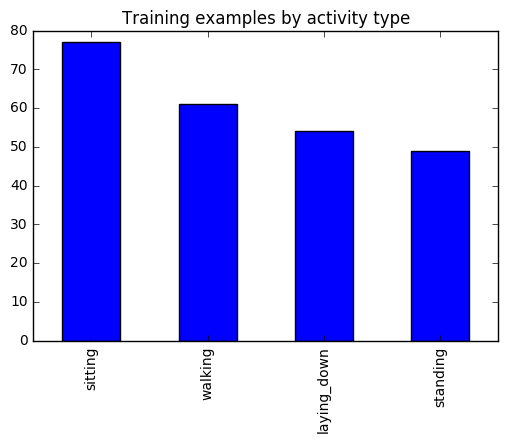

,mean_acc_x,mean_acc_y,mean_acc_z,std_acc_x,std_acc_y,std_acc_z,mad_acc_x,mad_acc_y,mad_acc_z,min_acc_x,...,std_mfgy_jerk,mad_mfgy_jerk,min_mfgy_jerk,max_mfgy_jerk,em_mfgy_jerk,iqr_mfgy_jerk,sma_mfgy_jerk,skew_mfgy_jerk,kurt_mfgy_jerk,idx_mfgy_jerk
33,2.766752,-5.620212,-4.253272,1.274890,4.001141,4.968234,0.861058,2.405195,2.380841,-0.507961,...,1107.631634,787.089329,369.126376,6304.403006,9.413842e+06,1612.245561,2861.292449,0.311262,2.551548,832.0
192,1.305884,-1.261114,8.433857,2.256954,3.642098,0.563214,0.456413,0.805582,0.290685,-4.297983,...,612.488971,398.853883,460.164187,4612.493720,3.815453e+06,805.165372,1854.807227,0.632278,3.786425,22.0
144,-6.170257,-7.286478,-1.777548,1.468508,2.360041,1.859090,1.004313,1.745025,1.134163,-11.102040,...,1381.192342,877.302842,729.825309,9326.553424,1.562331e+07,1814.065770,3703.459852,0.759168,3.450777,180.0
11,3.862147,-8.913618,-1.631911,0.130231,2.083705,0.215592,0.041440,0.022318,0.050673,3.217985,...,1159.297859,736.572607,805.457656,8481.740311,1.158101e+07,1508.542646,3199.537699,0.772122,3.713802,136.0
106,-1.646043,-6.470183,-3.640172,5.911502,2.074375,2.474632,2.730464,1.099797,1.554656,-9.487904,...,544.328254,360.292849,323.625419,3721.806916,2.945374e+06,718.941858,1627.599774,0.520601,3.204321,1084.0


In [16]:
testing_set_df.to_csv("vidushi_288_10sc.csv")
hist_activities(testing_set_df)
# plot_act_signals(in_df_ac)

combined_testing_df = testing_set_df
combined_testing_df = combined_testing_df.iloc[np.random.permutation(len(combined_testing_df))]
combined_testing_df.head()

In [20]:
testing_data = combined_testing_df[tacc_cols+tacc_jerk_cols+tacc_mag_cols+tacc_jmag_cols+facc_cols+facc_jerk_cols+facc_mag_cols+facc_jmag_cols+tgy_jerk_cols+tgy_mag_cols+tgy_jmag_cols+fgy_cols+fgy_jerk_cols+fgy_mag_cols+fgy_jmag_cols+tgy_cols].as_matrix()
testing_targets = testing_data[:, -1]
testing_data = testing_data[:, :-1]

std_scale = preprocessing.StandardScaler().fit(testing_data)
testing_data_std = std_scale.transform(testing_data)

print(len(testing_data_std), len(testing_data_std[0]))
print(len(testing_targets))

cache = {'laying_down' : 0, 'sitting' : 1, 'walking' : 2, 'standing' : 3}
testing_targets.reshape(len(testing_targets))
print(testing_targets.shape)

testing_bin_targets = []
for i in testing_targets:
    testing_bin_targets.append(cache[i])
print(len(testing_bin_targets))

testing_bin_targets[: 5]

64 288
64
(64,)
64


/Users/gringotts/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[2, 2, 2, 2, 2]

In [21]:
model = DecisionTreeClassifier(random_state=0)

# Training the model
model.fit(training_data, training_bin_targets)

# Testing on the testing data
predicted_values = model.predict(testing_data)

In [22]:
acc_score = accuracy_score(testing_bin_targets, predicted_values)
print("Score: ", acc_score)

Score:  1.0
